# Forecasting Energy Demand Using PJM Data
PJM Hourly Energy Consumption Data
PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

# Goal
Create a model that will accurately forecast energy demand. Compare traditional stats models with more modern deep-learning frameworks. This will be helpful for the organization to balance energy loads on their infrastructure and have employees on call during peak periods.

# Imports

In [23]:
# =====================================================
# Energy Forecasting — PJM + NOAA temperature + Models
# Colab-ready: ARIMA, SARIMA, LSTM (Sequential), GRU (Functional),
# TCN (Functional) + PDF technical report
# =====================================================

# -------------------------
# 0) Install packages
# -------------------------
# run this cell first in Colab (uncomment it)
#!pip install -q tensorflow statsmodels pmdarima meteostat holidays kaggle scikit-learn matplotlib seaborn
! pip install -q meteostat

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'hourly-energy-consumption' dataset.
Path to dataset files: /kaggle/input/hourly-energy-consumption


In [24]:
# (Optional) if you want to use the Kaggle CLI to download PJM dataset:
# Place your kaggle.json in ~/.kaggle/kaggle.json or upload via Colab files.
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d robikscube/hourly-energy-consumption
# !unzip -q hourly-energy-consumption.zip

# -------------------------
# 1) Imports & settings
# -------------------------
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Dropout, Conv1D, BatchNormalization, Activation, Add, GlobalAveragePooling1D

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from meteostat import Point, Daily
import holidays

import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid')
print("TensorFlow version:", tf.__version__)
device_name = tf.test.gpu_device_name()
print("GPU available:", device_name if device_name else "No GPU detected")


TensorFlow version: 2.19.0
GPU available: No GPU detected


No GPU is detected as I am running a CPU currently. This can be switched in Google Colab after running the code to set a benchmark for time.

# Data Loading and Exploration

In [30]:
# =====================================================
# 2️⃣ Load and Explore Dataset
# =====================================================
# Kaggle PJM hourly energy dataset (download manually or via kagglehub)
# https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption
file_path = "PJM_Load_hourly.csv"  # change if necessary
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Please upload '{file_path}' to Colab or change file_path.")

df_raw = pd.read_csv(file_path, parse_dates=['Datetime'], index_col='Datetime')
print("Original shape:", df_raw.shape)
df_raw = df_raw.sort_index()

# Inspect columns
print("Columns:", df_raw.columns.tolist())
# Assume main load column named something like 'PJM_Load_MW' or 'Load_MW' - find a load column
load_col = None
for c in df_raw.columns:
    if 'load' in c.lower() or 'mw' in c.lower():
        load_col = c
        break
if load_col is None:
    # fallback to first numeric column
    numeric_cols = df_raw.select_dtypes('number').columns
    if len(numeric_cols) > 0:
        load_col = numeric_cols[0]
    else:
        raise ValueError("Couldn't find a load column—please check the CSV.")

Original shape: (32896, 1)
Columns: ['PJM_Load_MW']


In [32]:
df_raw.head()

,PJM_Load_MW
Datetime,
1998-04-01 01:00:00,22259.0
1998-04-01 02:00:00,21244.0
1998-04-01 03:00:00,20651.0
1998-04-01 04:00:00,20421.0
1998-04-01 05:00:00,20713.0


In [33]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32896 entries, 1998-04-01 01:00:00 to 2002-01-01 00:00:00
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PJM_Load_MW  32896 non-null  float64
dtypes: float64(1)
memory usage: 514.0 KB


We have a simple dataset containing a datetime and the load (in MegaWatts) provided by PJM.

Data:
Datetime: YYYY-MM-DD HH:MM:00 <br>
PJM_Load_MW: float64

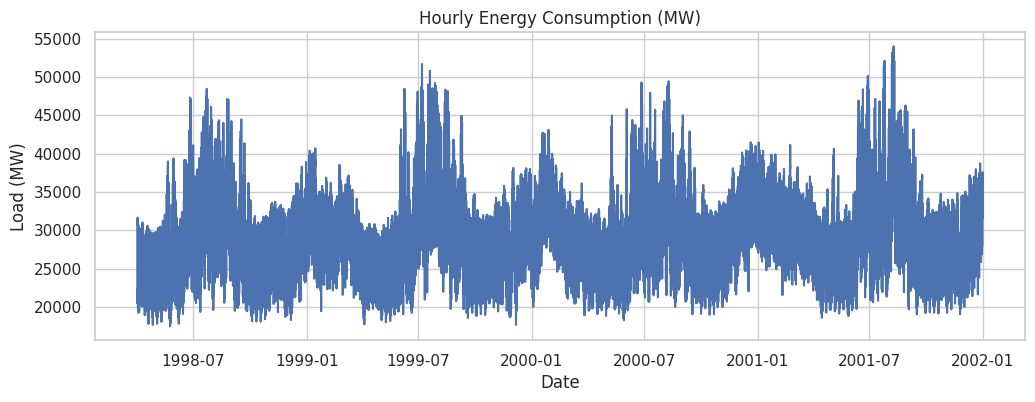

In [35]:
# Plot the data
plt.figure(figsize=(12,4))
plt.plot(df_raw.index, df_raw['PJM_Load_MW'])
plt.title("Hourly Energy Consumption (MW)")
plt.xlabel("Date"); plt.ylabel("Load (MW)")
plt.show()

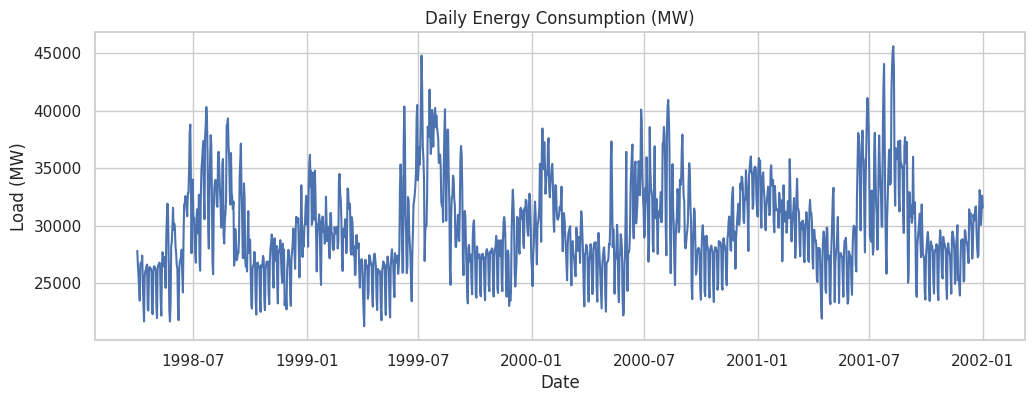

In [38]:
# We currently have hourly data, but I think it makes more sense to try forecasting the
# the load for daily mean. Let's resample the data.
df_daily = df_raw.resample('D').mean()  # daily average

plt.figure(figsize=(12,4))
plt.plot(df_daily.index, df_daily['PJM_Load_MW'])
plt.title("Daily Energy Consumption (MW)")
plt.xlabel("Date"); plt.ylabel("Load (MW)")
plt.show()


In [56]:
print(len(df_daily))
df_daily.head()

1372


,PJM_Load_MW
Datetime,
1998-04-01,27813.739130
1998-04-02,26605.791667
1998-04-03,25672.333333
1998-04-04,24487.083333
1998-04-05,23487.565217


In [53]:
# -------------------------
# 3) Fetch NOAA temperature (via meteostat) for a representative location
# -------------------------
# Choose a point roughly central to PJM region — e.g., Philadelphia coordinates (39.9526, -75.1652)
# Adjust as needed or let user change coordinates.

# Import Meteostat library
from meteostat import Stations

lat, lon = 39.9526, -75.1652
# Get nearby weather stations
stations = Stations()
stations = stations.nearby(lat, lon)
station = stations.fetch(1)

start = df_daily.index.min()
end = df_daily.index.max()
print("Temperature fetch range:", start, "to", end)

Temperature fetch range: 1998-04-01 00:00:00 to 2002-01-01 00:00:00


In [54]:
station.index[0]

'72408'

In [55]:
# meteostat Daily (gives tavg, tmin, tmax) - note: sometimes contains NaNs for tavg; we'll compute from tmin/tmax if needed.
temp_daily = Daily(station.index[0], start, end)
temp_daily = temp_daily.fetch().rename(columns={'tavg':'tavg_c','tmin':'tmin_c','tmax':'tmax_c'})
# Some stations lack tavg: compute average if possible
if 'tavg_c' not in temp_daily.columns or temp_daily['tavg_c'].isna().all():
    if 'tmin_c' in temp_daily.columns and 'tmax_c' in temp_daily.columns:
        temp_daily['tavg_c'] = (temp_daily['tmin_c'] + temp_daily['tmax_c'])/2.0

temp_daily = temp_daily[['tavg_c']].rename(columns={'tavg_c':'temp_c'})
temp_daily = temp_daily.reset_index().set_index('time')
temp_daily.index = pd.to_datetime(temp_daily.index.date)

print("Temperature shape and sample:")
print(temp_daily.head())

Temperature shape and sample:
            temp_c
1998-04-01    19.4
1998-04-02    17.2
1998-04-03    11.7
1998-04-04     8.3
1998-04-05     8.3


In [64]:
# Merge temperature into main DF (align on date)
df = df_daily.copy()
df.index = pd.to_datetime(df.index.date)  # align indexing to date
df.index.name = 'date'
df = df.join(temp_daily, how='left')
# forward/backfill small gaps in temperature
df['temp_c'] = df['temp_c'].interpolate().fillna(method='bfill').fillna(method='ffill')


In [65]:
df.head()

,PJM_Load_MW,temp_c
date,,
1998-04-01,27813.739130,19.4
1998-04-02,26605.791667,17.2
1998-04-03,25672.333333,11.7
1998-04-04,24487.083333,8.3
1998-04-05,23487.565217,8.3


# Feature Engineering

In [59]:
# -------------------------
# 4) Feature Engineering: time features + holidays + lags + rolling
# -------------------------
us_holidays = holidays.US()

def make_features(df):
    # We want some information about the day of the week and whether or not
    # it is a holiday or weekend.
    out = df.copy()
    out['dayofweek'] = out.index.to_series().dt.dayofweek
    out['dayofyear'] = out.index.to_series().dt.dayofyear
    out['month'] = out.index.to_series().dt.month
    out['is_weekend'] = out['dayofweek'].isin([5,6]).astype(int)
    out['is_holiday'] = out.index.to_series().apply(lambda d: 1 if d in us_holidays else 0)
    # Lags and rolling can be helpful in future prediction
    out['lag_1'] = out['load'].shift(1)
    out['lag_7'] = out['load'].shift(7)
    out['roll_7_mean'] = out['load'].shift(1).rolling(7).mean()
    out['roll_30_mean'] = out['load'].shift(1).rolling(30).mean()
    # Fill any NaNs produced by shifts
    out = out.fillna(method='bfill').fillna(method='ffill')
    return out

In [66]:
df.rename(columns={'PJM_Load_MW':'load'}, inplace=True)

In [67]:
df_fe = make_features(df)
df_fe.head()

,load,temp_c,dayofweek,dayofyear,month,is_weekend,is_holiday,lag_1,lag_7,roll_7_mean,roll_30_mean
date,,,,,,,,,,,
1998-04-01,27813.739130,19.4,2,91,4,0,0,27813.739130,27813.73913,25936.001812,25429.8657
1998-04-02,26605.791667,17.2,3,92,4,0,0,27813.739130,27813.73913,25936.001812,25429.8657
1998-04-03,25672.333333,11.7,4,93,4,0,0,26605.791667,27813.73913,25936.001812,25429.8657
1998-04-04,24487.083333,8.3,5,94,4,1,0,25672.333333,27813.73913,25936.001812,25429.8657
1998-04-05,23487.565217,8.3,6,95,4,1,0,24487.083333,27813.73913,25936.001812,25429.8657


In [68]:
# -------------------------
# 5) Train-test split (time-based)
# -------------------------
# We'll use last 20% as test
split_idx = int(len(df_fe) * 0.8)
train_df = df_fe.iloc[:split_idx].copy()
test_df = df_fe.iloc[split_idx:].copy()
print("Train:", train_df.shape, "Test:", test_df.shape)

# features and target
feature_cols = ['temp_c','dayofweek','dayofyear','month','is_weekend','is_holiday',
                'lag_1','lag_7','roll_7_mean','roll_30_mean']
target_col = 'load'

# -------------------------
# 6) Scale features
# -------------------------
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(train_df[feature_cols].values)
X_test = scaler_X.transform(test_df[feature_cols].values)

y_train = scaler_y.fit_transform(train_df[[target_col]].values).flatten()
y_test = scaler_y.transform(test_df[[target_col]].values).flatten()

Train: (1097, 11) Test: (275, 11)


Deep learning models (LSTM, GRU, TCN, etc.) don’t inherently understand “time.”
They need data structured as input–output pairs, just like normal regression or classification tasks.

However, a raw time series is just a 1D sequence of values like this:

|t:   |1  |2  |3  |4  |5  |6  |7  |
|-----|---|---|---|---|---|---|---|
|Load |340|350|360|355|370|390|400|

If you want the model to predict the next value based on the previous values, you must restructure the series into something like:

| Past 3 Days (Inputs) | Next Day (Target) |
| -------------------- | ----------------- |
| [340, 350, 360]      | 355               |
| [350, 360, 355]      | 370               |
| [360, 355, 370]      | 390               |
| [355, 370, 390]      | 400               |

Time series forecasting fundamentally requires learning temporal dependencies — patterns over time.

The sliding window provides the model with context:

“Here are the last 30 readings — what should the next one be?”

RNNs (like LSTM or GRU) then process these sequences step-by-step, maintaining internal “memory” of what came before.

Without the sliding window:

The model would just see isolated points, losing temporal order.

It couldn’t learn trends, seasonality, or lag effects.

In [69]:
# For sequence models, we will create sliding windows (multivariate)
def make_sequences(X, y, window):
    Xs, ys = [], []
    for i in range(window, len(X)):
        Xs.append(X[i-window:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

In [70]:
window = 30  # 30 days lookback
X_seq_train, y_seq_train = make_sequences(X_train, y_train, window)
X_seq_test, y_seq_test = make_sequences(np.vstack([X_train[-window:], X_test]),
                                        np.concatenate([y_train[-window:], y_test]),
                                        window)
# The above aligns test sequences to actual time.
# Now trim first test length to match original test size
# Ensure alignments
# (we will base evaluations on y_seq_test corresponding to test_df period)
print("X_seq_train shape:", X_seq_train.shape,
      "y_seq_train shape:", y_seq_train.shape)
print("X_seq_test shape:", X_seq_test.shape,
      "y_seq_test shape:", y_seq_test.shape)

X_seq_train shape: (1067, 30, 10) y_seq_train shape: (1067,)
X_seq_test shape: (275, 30, 10) y_seq_test shape: (275,)


In [71]:
# derive corresponding dates for y_seq_test
all_dates = np.concatenate([train_df.index.values, test_df.index.values])
dates_seq = all_dates[window:]  # sequence target dates
dates_test_seq = dates_seq[len(train_df)-window:]  # test target dates
len(dates_test_seq), len(y_seq_test)

(275, 275)

# Baseline Models

In [72]:
# -------------------------
# 7) Baselines: ARIMA and SARIMA on univariate load (train target)
# -------------------------
# Fit ARIMA on raw (unscaled) train load series
arima_order = (5,1,0)
arima_model = ARIMA(train_df['load'], order=arima_order)
arima_res = arima_model.fit()
arima_forecast = arima_res.forecast(steps=len(test_df))

In [73]:
# SARIMA with weekly seasonality (period=7)
sarima_order = (1,1,1)
seasonal_order = (1,1,1,7)
sarima_model = SARIMAX(train_df['load'], order=sarima_order, seasonal_order=seasonal_order)
sarima_res = sarima_model.fit(disp=False)
sarima_forecast = sarima_res.forecast(steps=len(test_df))

In [74]:
# Evaluate baseline (unscaled)
def metrics(true, pred, name):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    mape = np.mean(np.abs((true - pred)/true)) * 100.0
    print(f"{name} — RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")
    return {'rmse':rmse, 'mae':mae, 'mape':mape}

In [75]:
baseline_arima_metrics = metrics(test_df['load'].values, arima_forecast.values, "ARIMA")
baseline_sarima_metrics = metrics(test_df['load'].values, sarima_forecast.values, "SARIMA")

ARIMA — RMSE: 4571.59, MAE: 3264.63, MAPE: 10.31%
SARIMA — RMSE: 4898.51, MAE: 4253.30, MAPE: 14.46%


# Deep Learning Models

In [76]:
# Common training params
BATCH_SIZE = 32
EPOCHS = 30
VERBOSE = 1

# Convert sequences to tf-compatible arrays
X_train_seq = X_seq_train.astype(np.float32)
y_train_seq = y_seq_train.astype(np.float32)
X_test_seq = X_seq_test.astype(np.float32)
y_test_seq = y_seq_test.astype(np.float32)

# Shape info
n_timesteps = X_train_seq.shape[1]
n_features = X_train_seq.shape[2]
print("Seq shape:", X_train_seq.shape, "timesteps:", n_timesteps, "features:", n_features)


Seq shape: (1067, 30, 10) timesteps: 30 features: 10


In [77]:
# ---- 8A) LSTM (Sequential API) ----
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(n_timesteps, n_features)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1, activation='linear')
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

history_lstm = lstm_model.fit(X_train_seq,
                              y_train_seq,
                              epochs=EPOCHS,
                              batch_size=BATCH_SIZE,
                              validation_split=0.1,
                              shuffle=False,
                              verbose=VERBOSE)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,649 (123.63 KB)

 Trainable params: 31,649 (123.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0571 - val_loss: 0.0119
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0261 - val_loss: 0.0096
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0227 - val_loss: 0.0089
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0227 - val_loss: 0.0087
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0203 - val_loss: 0.0080
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0207 - val_loss: 0.0086
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0200 - val_loss: 0.0074
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0198 - val_loss: 0.0077
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0201 - val_loss: 0.0085
Epoch 10/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0192 - val_loss: 0.0084
Epoch 11/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0190 - val_loss: 0.0065
Epoch 12/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0

In [78]:
# ---- 8B) GRU (Functional API) ----
inputs = Input(shape=(n_timesteps, n_features), name='input_gru')
x = GRU(64, return_sequences=True)(inputs)
x = Dropout(0.2)(x)
x = GRU(32)(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='linear')(x)
gru_model = Model(inputs=inputs, outputs=outputs, name='GRU_model')
gru_model.compile(optimizer='adam', loss='mse')
gru_model.summary()

history_gru = gru_model.fit(X_train_seq, y_train_seq, epochs=EPOCHS, batch_size=BATCH_SIZE,
                            validation_split=0.1, shuffle=False, verbose=VERBOSE)

Model: "GRU_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_gru (InputLayer)          │ (None, 30, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 30, 64)         │        14,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,033 (93.88 KB)

 Trainable params: 24,033 (93.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 0.0629 - val_loss: 0.0099
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0243 - val_loss: 0.0073
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0195 - val_loss: 0.0064
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0184 - val_loss: 0.0067
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0184 - val_loss: 0.0058
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0173 - val_loss: 0.0050
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0173 - val_loss: 0.0060
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0163 - val_loss: 0.0059
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0162 - val_loss: 0.0054
Epoch 10/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0164 - val_loss: 0.0053
Epoch 11/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0157 - val_loss: 0.0059
Epoch 12/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0

In [79]:
# ---- 8C) TCN (Functional API) — simple dilated conv-based TCN block ----
def tcn_block(x, filters, kernel_size, dilation_rate):
    prev = x
    # 1D conv
    x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # second conv
    x = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # residual connection if shapes match
    if prev.shape[-1] != filters:
        prev = Conv1D(filters, 1, padding='same')(prev)
    x = Add()([prev, x])
    return x

In [80]:
inputs = Input(shape=(n_timesteps, n_features), name='input_tcn')
x = inputs
# stack dilations 1, 2, 4
for d in [1, 2, 4]:
    x = tcn_block(x, filters=64, kernel_size=3, dilation_rate=d)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='linear')(x)
tcn_model = Model(inputs=inputs, outputs=outputs, name='TCN_model')
tcn_model.compile(optimizer='adam', loss='mse')
tcn_model.summary()

history_tcn = tcn_model.fit(X_train_seq, y_train_seq, epochs=EPOCHS, batch_size=BATCH_SIZE,
                            validation_split=0.1, shuffle=False, verbose=VERBOSE)

Model: "TCN_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_tcn           │ (None, 30, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 30, 64)    │      1,984 │ input_tcn[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 30, 64)    │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 30, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 30, 64)    │     12,352 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 64)    │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 30, 64)    │        704 │ input_tcn[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 30, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 30, 64)    │          0 │ conv1d_2[0][0],   │
│                     │                   │            │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 30, 64)    │     12,352 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 64)    │        256 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 30, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 30, 64)    │     12,352 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 64)    │        256 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 30, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 30, 64)    │          0 │ add[0][0],        │
│                     │                   │            │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 30, 64)    │     12,352 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 64)    │        256 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 30, 64)    │          0 │ batch_normalizat

 Total params: 66,049 (258.00 KB)

 Trainable params: 65,281 (255.00 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 2.3578 - val_loss: 0.0109
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7800 - val_loss: 0.0234
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.6979 - val_loss: 0.0309
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.5649 - val_loss: 0.0500
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.4647 - val_loss: 0.0689
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.3959 - val_loss: 0.0812
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.3359 - val_loss: 0.0805
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2801 - val_loss: 0.0459
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.2608 - val_loss: 0.0433
Epoch 10/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.2151 - val_loss: 0.0428
Epoch 11/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.1998 - val_loss: 0.0306
Epoch 12/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1

# Prediction and Evaluation

In [81]:
# -------------------------
# 9) Predictions and rescaling
# -------------------------
# Predict with LSTM, GRU, TCN on test sequences (y_seq_test are scaled)
pred_lstm = lstm_model.predict(X_test_seq).flatten()
pred_gru = gru_model.predict(X_test_seq).flatten()
pred_tcn = tcn_model.predict(X_test_seq).flatten()

# Inverse scale predictions and y_test_seq
pred_lstm_inv = scaler_y.inverse_transform(pred_lstm.reshape(-1,1)).flatten()
pred_gru_inv = scaler_y.inverse_transform(pred_gru.reshape(-1,1)).flatten()
pred_tcn_inv = scaler_y.inverse_transform(pred_tcn.reshape(-1,1)).flatten()
y_test_inv = scaler_y.inverse_transform(y_test_seq.reshape(-1,1)).flatten()

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


In [82]:
# Match predicted dates to test_df dates
pred_dates = pd.to_datetime(dates_test_seq)

In [83]:
# Build a comparison DataFrame aligned with test_df period (length should match len(test_df))
comp_df = pd.DataFrame({
    'date': pred_dates,
    'actual': y_test_inv,
    'LSTM': pred_lstm_inv,
    'GRU': pred_gru_inv,
    'TCN': pred_tcn_inv
}).set_index('date')

In [84]:
# For baseline ARIMA/SARIMA we already have forecasts aligned to test_df index
baseline_df = pd.DataFrame({
    'date': test_df.index,
    'actual': test_df['load'].values,
    'ARIMA': arima_forecast.values,
    'SARIMA': sarima_forecast.values
}).set_index('date')

In [85]:
# For fairness, align comp_df and baseline_df on the overlapping dates (comp_df index should be subset of baseline index)
common_idx = comp_df.index.intersection(baseline_df.index)
comp_df = comp_df.loc[common_idx]
baseline_df = baseline_df.loc[common_idx]


In [86]:
# -------------------------
# 10) Evaluate all models (common date range)
# -------------------------
results = {}
# Baselines
results['ARIMA'] = metrics(baseline_df['actual'].values, baseline_df['ARIMA'].values, "ARIMA")
results['SARIMA'] = metrics(baseline_df['actual'].values, baseline_df['SARIMA'].values, "SARIMA")
# Deep models
results['LSTM'] = metrics(comp_df['actual'].values, comp_df['LSTM'].values, "LSTM")
results['GRU']  = metrics(comp_df['actual'].values, comp_df['GRU'].values, "GRU")
results['TCN']  = metrics(comp_df['actual'].values, comp_df['TCN'].values, "TCN")

print(results)

ARIMA — RMSE: 4571.59, MAE: 3264.63, MAPE: 10.31%
SARIMA — RMSE: 4898.51, MAE: 4253.30, MAPE: 14.46%
LSTM — RMSE: 3011.87, MAE: 2144.54, MAPE: 6.91%
GRU — RMSE: 2618.53, MAE: 1833.27, MAPE: 5.88%
TCN — RMSE: 5398.44, MAE: 4055.35, MAPE: 12.66%
{'ARIMA': {'rmse': np.float64(4571.58854151792), 'mae': 3264.631905250219, 'mape': np.float64(10.311425142054025)}, 'SARIMA': {'rmse': np.float64(4898.506718839966), 'mae': 4253.2996059599955, 'mape': np.float64(14.463388271837923)}, 'LSTM': {'rmse': np.float64(3011.8749974061006), 'mae': 2144.541748046875, 'mape': np.float32(6.9070764)}, 'GRU': {'rmse': np.float64(2618.5321269749584), 'mae': 1833.2689208984375, 'mape': np.float32(5.8847322)}, 'TCN': {'rmse': np.float64(5398.437736975393), 'mae': 4055.352783203125, 'mape': np.float32(12.655234)}}


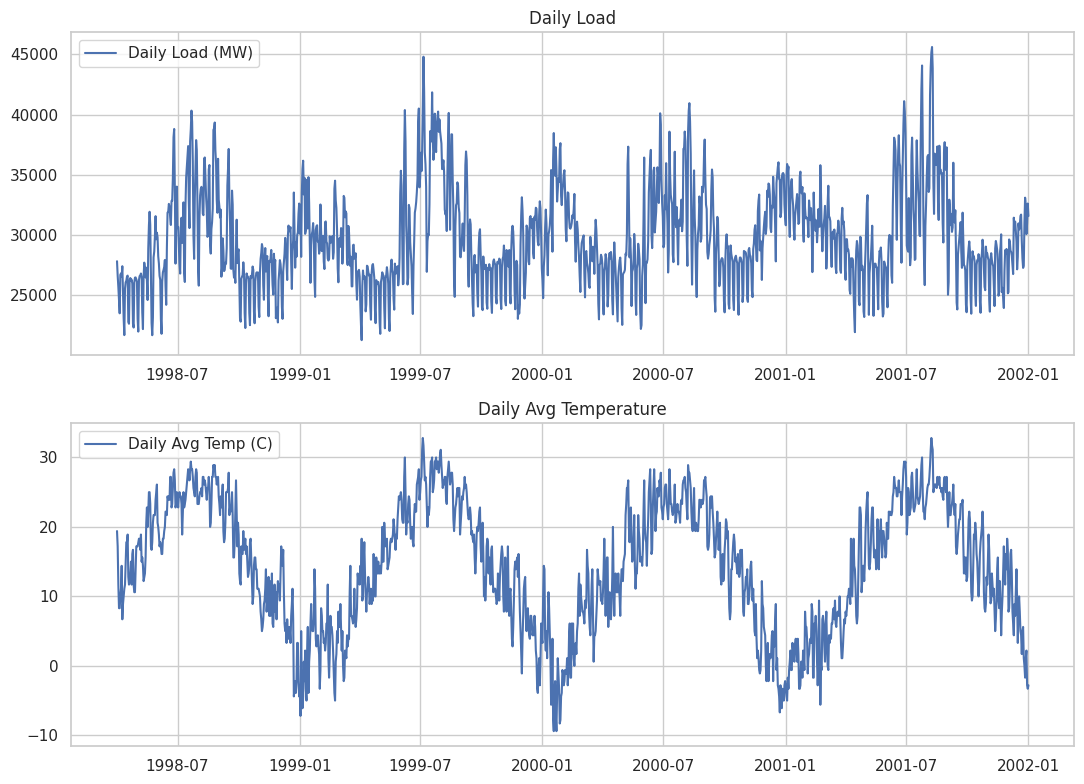

In [89]:
fig, ax = plt.subplots(2,1, figsize=(11,8))
ax[0].plot(df.index, df['load'], label='Daily Load (MW)')
ax[0].set_title('Daily Load')
ax[0].legend()
ax[1].plot(df.index, df['temp_c'], label='Daily Avg Temp (C)')
ax[1].set_title('Daily Avg Temperature')
ax[1].legend()
plt.tight_layout()

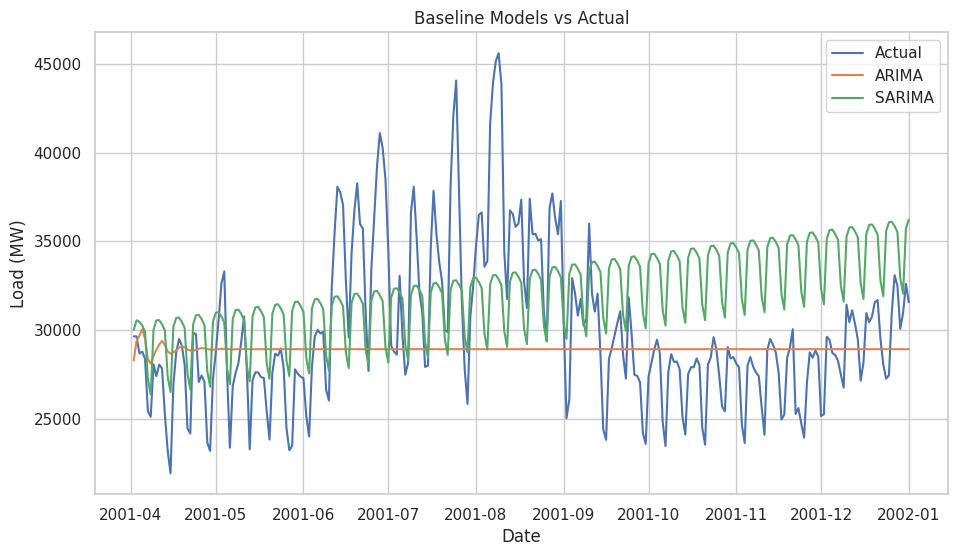

In [92]:
# Baseline forecasts vs actual
fig = plt.figure(figsize=(11,6))
plt.plot(baseline_df.index, baseline_df['actual'], label='Actual')
plt.plot(baseline_df.index, baseline_df['ARIMA'], label='ARIMA')
plt.plot(baseline_df.index, baseline_df['SARIMA'], label='SARIMA')
plt.title('Baseline Models vs Actual')
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.legend()

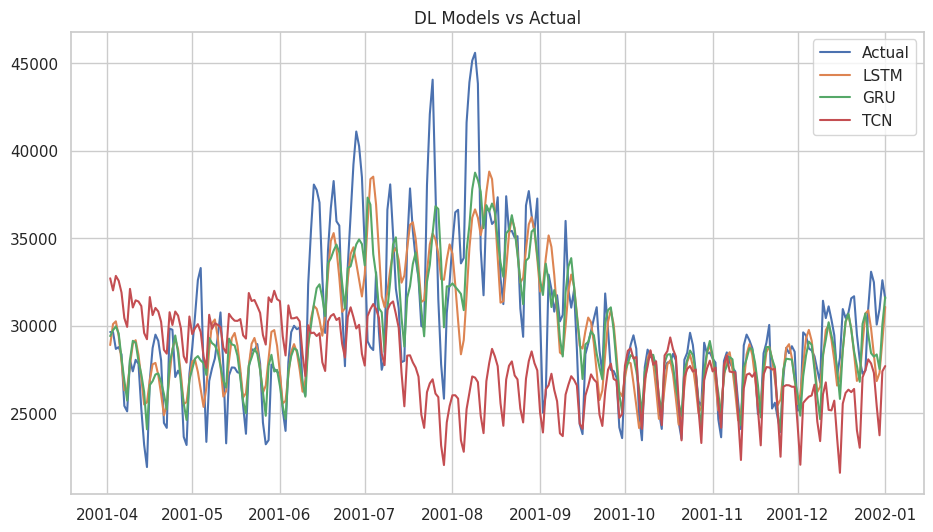

In [91]:
# Page 4: Deep learning forecasts vs actual
fig = plt.figure(figsize=(11,6))
plt.plot(comp_df.index, comp_df['actual'], label='Actual')
plt.plot(comp_df.index, comp_df['LSTM'], label='LSTM')
plt.plot(comp_df.index, comp_df['GRU'], label='GRU')
plt.plot(comp_df.index, comp_df['TCN'], label='TCN')
plt.title('DL Models vs Actual')
plt.legend()

Text(0.01, 0.18, 'Notes:\n- All deep models are multivariate (load + temp + time features)\n- Baselines are univariate (load only)')

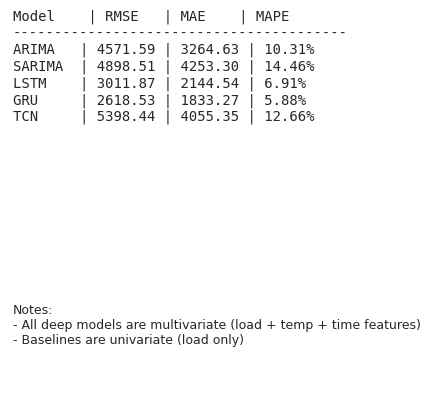

In [96]:
# Create table showing evaluation metrics
fig = plt.figure(figsize=(4,4))
plt.axis('off')
rows = []
for name, m in results.items():
    rows.append([name, f"{m['rmse']:.2f}", f"{m['mae']:.2f}", f"{m['mape']:.2f}%"])
# Render as text table
table_text = "Model    | RMSE   | MAE    | MAPE\n"
table_text += "-"*40 + "\n"
for r in rows:
    table_text += f"{r[0]:7s} | {r[1]:6s} | {r[2]:6s} | {r[3]:6s}\n"
plt.text(0.01, 0.85, table_text, fontfamily='monospace', fontsize=10)
plt.text(0.01,0.18, "Notes:\n- All deep models are multivariate (load + temp + time features)\n- Baselines are univariate (load only)", fontsize=9)


# Results and Discussion
We can see from the figures and evaluation metrics that the deep learning models perfrom much better at predicting the energy load than the baseline statistical models. However, it is important to note that the statistal models were run on univariate data while the deep learning models were run using additional features that include temperature and engineered temporal features which gives them somewhat of an unfair advantage.

We see that, of the neural networks used - Gated Recurrent Units (GRU), Long Short-Term Memory Units (LSTM), and Temporal Convolutional Units (TCN) - the GRUs and LSTMs achieved the highest accuracies. I would recommend using the GRU in production as it has both the best performance and least training time.

# Caveats and Future Work
I would recommend adding additional features that are known to impact energy consumption. It would also be useful to add information about known climate trends using longer time-series temperature data and additional locations. Our model only had temperature information chosen from a single station at a somewhat arbitrary point in PJMs network.

Future work would include further feature exploration and model tuning (hyperparameters and model architecture).